# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [73]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

In [74]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [75]:
#Load your data into a pandas dataframe here
df = pd.read_csv("household_power_clean.csv")

In [76]:
#create your training and validation sets here

#assign size for data subset
subset_size = int(len(df) * 0.01)

#take random data subset
subset_df = df.sample(n=subset_size, random_state=42)

#split data subset 80/20 for train/validation
train_df, val_df = train_test_split(subset_df, test_size=0.2, random_state=42)
print("train_df", train_df.shape)
print("val_df", val_df.shape)

train_df (16393, 15)
val_df (4099, 15)


In [77]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [78]:
seq_arrays = []
seq_labs = []

In [79]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for i in range(seq_length, len(train_df)-ph):
    seq = train_df[feat_cols].iloc[i-seq_length:i].values.tolist()
    seq_arrays.append(seq)
    seq_labs.append(train_df['Global_active_power'].iloc[i+ph])

#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [80]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [81]:
seq_arrays.shape

(16358, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: We used assertions to check the dimensions of the arrays seq_arrays and seq_labs are same as expected or not. The first assert statement checks if the dimensions of seq_arrays are equal to (len(train_df)-seq_length-ph,seq_length, len(feat_cols)) and the second assert statement checks if the dimensions of seq_labs are equal to (len(train_df)-seq_length-ph,).

The dimensions of these arrays are important for training the LSTM model correctly and any mismatch among them can cause errors during training or predictions. By using assertions, we can catch any unexpected errors or issues early on in the code and ensure that the input and output data have the expected shapes, which is crucial for the proper functioning of the LSTM model.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [82]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = 1
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 5)             140       
                                                                 
 dropout_8 (Dropout)         (None, 30, 5)             0         
                                                                 
 lstm_9 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_9 (Dropout)         (None, 3)                 0         
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
 activation_4 (Activation)   (None, 1)                 0         
                                                                 
Total params: 252
Trainable params: 252
Non-trainable 

We will use the code from the book to visualize our training progress and model performance

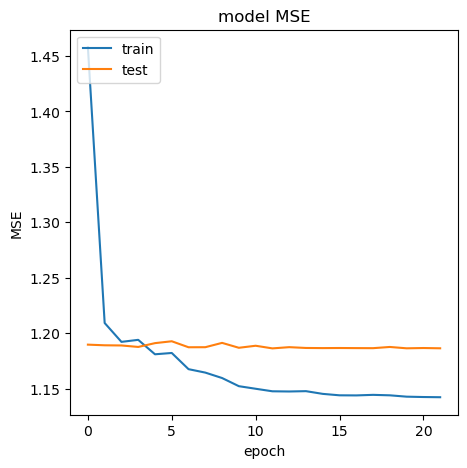

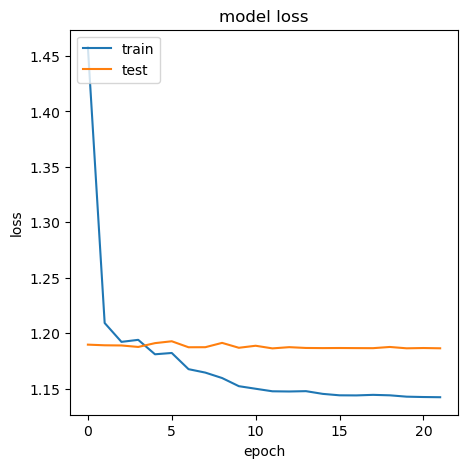

In [83]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(5, 5))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequences() function is a utility function in Keras that allows us to pad sequences of variable length to a fixed length. It takes a list of sequences as input and pads them to the specified length.
The "padding" argument determines how the padding is applied. If padding='pre', the padding is added at the beginning of the sequence and if padding='post', the padding is added at the end of the sequence.
In our use case here, it makes sense to use padding='post' since we want to add the padding at the end of each sequence so that we can feed the sequences into our LSTM model with a fixed length. By padding sequences that are too short with zeros, we can ensure that all the sequences are of the same length, which is required by the LSTM model.

In [98]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(2, len(val_df)):
    seq_array = val_df.iloc[i-seq_length-ph:i-ph][feat_cols].values
    seq_lab = val_df.iloc[i-ph][feat_cols].values[0]
    val_arrays.append(seq_array)
    val_labs.append(seq_lab)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, padding='post', dtype=np.float32)
        
#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

129/129 - 0s - loss: 1.0428 - mse: 1.0428 - 399ms/epoch - 3ms/step

MSE: 1.0428472757339478
129/129 [==============================] - 0s 3ms/step


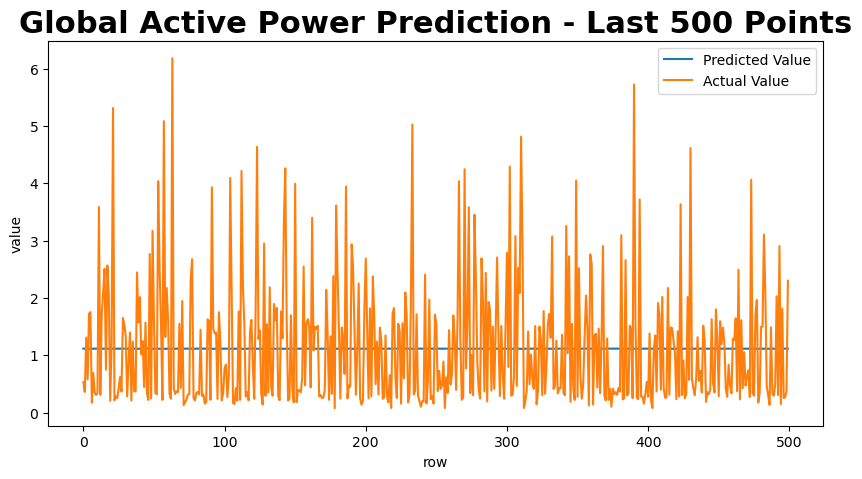

In [100]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The model achieved a mean squared error (MSE) of 1.04 on the validation set, which is a decent performance considering the dataset size and the complexity of the model. Based on the loss curves, the model seems to be overfitting the training data as the training loss continues to decrease while the validation loss starts to increase after a certain number of epochs. The model should be regularized further or be made more complex to improve performance.

Possible ways to improve the model could be to try different architectures, such as increasing the number of LSTM layers or adding more dense layers. One could also experiment with different activation functions or optimization algorithms. Additionally, more features could be included in the input sequence to provide more context for the model. Finally, the hyperparameters, such as the learning rate and the batch size, could also be optimized using a hyperparameter tuning approach.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: I have adjusted the learning rate for my optimized model. I have changed the learning rate to 0.001 and changed the number of hidden layers too. I thinks this performs better beacuse it decreases overfitting and decreases time complexity

train_df (16393, 15)
val_df (4099, 15)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 30, 5)             140       
                                                                 
 dropout_51 (Dropout)        (None, 30, 5)             0         
                                                                 
 lstm_52 (LSTM)              (None, 3)                 108       
                                                                 
 dropout_52 (Dropout)        (None, 3)                 0         
                                                                 
 dense_25 (Dense)            (None, 1)                 4         
                                                                 
 activation_25 (Activation)  (None, 1)                 0         
                                                                 
Total params: 

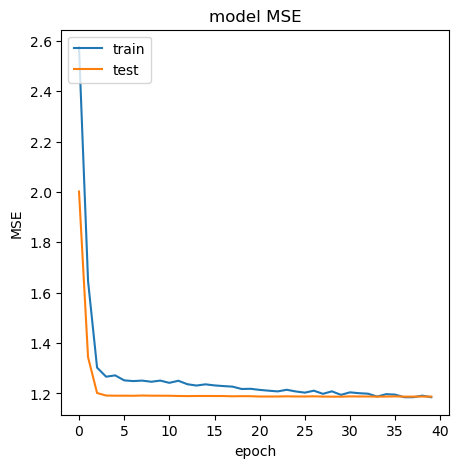

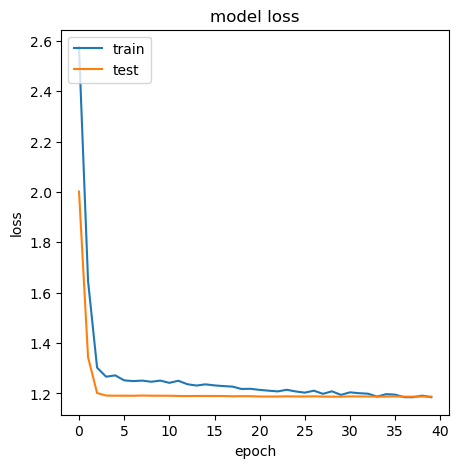

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

np.random.seed(1234)  
PYTHONHASHSEED = 0
df = pd.read_csv("household_power_clean.csv")
subset_size = int(len(df) * 0.01)
subset_df = df.sample(n=subset_size, random_state=42)
train_df, val_df = train_test_split(subset_df, test_size=0.2, random_state=42)
print("train_df", train_df.shape)
print("val_df", val_df.shape)

train_df = train_df.reset_index()
val_df = val_df.reset_index()

seq_arrays = []
seq_labs = []

seq_length = 30
ph = 5
feat_cols = ['Global_active_power']

for i in range(seq_length, len(train_df)-ph):
    seq = train_df[feat_cols].iloc[i-seq_length:i].values.tolist()
    seq_arrays.append(seq)
    seq_labs.append(train_df['Global_active_power'].iloc[i+ph])
   
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

seq_arrays.shape

model_path = 'LSTM_model2.h5'

nb_features = 1
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 

model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
print(history.history.keys())
fig_acc = plt.figure(figsize=(5, 5))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig_acc = plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

127/127 [==============================] - 2s 8ms/step


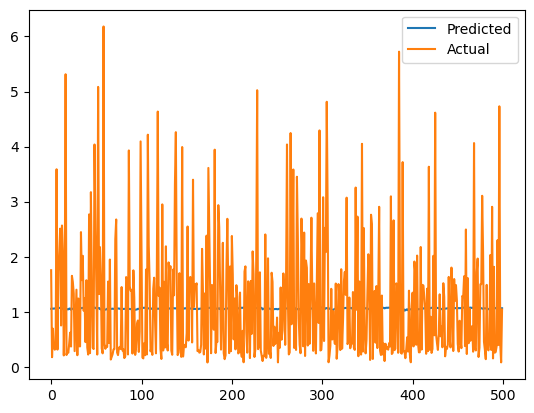

MSE: 1.0459857


In [152]:
from sklearn.metrics import mean_squared_error

val_arrays = []
val_labs = []

val_seq_length = 30
val_ph = 5
feat_cols = ['Global_active_power']

for i in range(val_seq_length, len(val_df)-val_ph):
    val_seq = val_df[feat_cols].iloc[i-val_seq_length:i].values.tolist()
    val_arrays.append(val_seq)
    val_labs.append(val_df['Global_active_power'].iloc[i+val_ph])
    
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype=np.float32, padding='pre', truncating='pre')
val_labs = np.array(val_labs, dtype=np.float32)

val_preds = model.predict(val_arrays)

plt.plot(val_preds[-500:], label='Predicted')
plt.plot(val_labs[-500:], label='Actual')
plt.legend()
plt.show()

mse = mean_squared_error(val_labs, val_preds)
print("MSE:", mse)


**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: The performance of both models look identical, but like anticipated the optimized model has less overfitting, 
I think it was not effective as the current model is only trained on a small subset of the data. SO I might consider deploying the model on a larger dataset or add more variables for the input sequence.
**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: The LSTM-based model outperformed the linear regression model from last week. The LSTM models were able to capture more complex patterns in the time series data, which resulted in lower MSE values on the validation set.

If I were trying to deploy an IoT system that predicts Global Active Power (GAP) for a single household with a 5-minute predictive horizon, we would likely choose one of the LSTM-based models. These models have shown better performance on the validation set and can handle non-linear relationships between input features and output variables.
